In [14]:
from tensorflow.keras.preprocessing import image_dataset_from_directory
import cv2
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
import numpy as np


def load_dataset(dir='caltech-101/101_ObjectCategories/', image_size=(96,96), batch_size=32):
    """Loads the Caltech-101 Dataset downloaded in directory `dir`.

    Args:
        dir (str): The directory where the caltech-101 dataset is stored. Defaults to 'caltech-101/101_ObjectCategories/'.
        image_size (int x int): The width and height of images to rescale directory dataset to.
        batch_size (int): The size of batches. Change depending on computational performance.

    Returns:
        tensorflow.BatchDataset: A Tensorflow BatchDataset.
    """
    try:
        caltech_dataset = image_dataset_from_directory(directory='caltech-101/101_ObjectCategories/',
                                                labels='inferred',
                                                label_mode='categorical',
                                                batch_size=batch_size,
                                                image_size=image_size)
    except:
        print("Please ensure you have downloaded the Caltech-101 Dataset from https://data.caltech.edu/records/mzrjq-6wc02,")
        print(f"and placed it into {dir}, or any different directory.")
    return caltech_dataset


def create_HOG_descriptors(dataset)->np.ndarray:
    """Creates HOG descriptors of an input dataset.

    Args:
        dataset (tf.BatchDataset): A batched Tensorflow dataset.

    Returns:
        np.ndarray: A nxp sized NumPy array were each row denotes a HOG descriptor of one input image.
    """
    winSize, blockSize, blockStride, cellSize = (64,64), (16,16), (8,8), (8,8)
    nbins, derivAperture, winSigma, histogramNormType = 9, 1, 4.0, 0
    L2HysThreshold, gammaCorrection, nlevels = 2e-1, 0, 64

    winStride, padding, locations = (8,8), (8,8), ((10,20),)

    hogs = []
    hog = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins,derivAperture,winSigma,
                            histogramNormType,L2HysThreshold,gammaCorrection,nlevels)
    for x,_ in dataset:
        for x_item in x:
            item = np.round(x_item.numpy()).astype(np.uint8)
            h = hog.compute(item,winStride,padding,locations)
            hogs.append(h.reshape(1,-1))
    return np.concatenate(hogs, axis=0)


def normalise_HOGs(hogs:np.ndarray)->np.ndarray:
    """Normalise HOG descriptor features with mean = 0, sd = 1.

    Args:
        hogs (np.ndarray): A nxp sized NumPy array of HOG descriptors.

    Returns:
        np.ndarray: A nxp sized NumPy array of HOG descriptors with normalised features.
    """
    for c in range(hogs.shape[1]):
        hogs[:,c] -= hogs[:,c].mean()
        if hogs[:,c].std() != 0:
            hogs[:,c] /= hogs[:,c].std()
    return hogs


def reduce_with_PCA(data:np.ndarray, n_components:int=50)->np.ndarray:
    """Do PCA on data, keeping the top `n_components`.

    Args:
        data (np.ndarray): A nxp sized NumPy array of data to do PCA with.
                           Features are assumed to be normalised.
                           The Euclidean distance metric is used.
        n_components (int, optional): The number of most varied features to keep. Defaults to 50.

    Returns:
        np.ndarray: A nxn_components sized NumPy array of PCA reduced data.
    """
    PCA_reduction = PCA(n_components=n_components)
    return PCA_reduction.fit_transform(data)


def KMeans_Elbow(data:np.ndarray, cluster_range=(2,100))->None:
    """Apply KMeans to data `cluster_range[1]-cluster_range[0]` times. 
       Compute and plot cluster distortions for each cluster count in `cluster_range`.
       Predict optimal cluster count based on the elbow method.

    Args:
        data (np.ndarray): A nxp sized NumPy array of data to apply KMeans clustering to.
        cluster_range (tuple, optional): The range of clusters of consider for KMeans and analysis. Defaults to (2,100).
    """
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=cluster_range)
    visualizer.fit(data)
    visualizer.show()


def KMeans_clustering(data:np.ndarray, n_clusters:int=45)->np.ndarray:
    """Apply KMeans clustering to `data` using `n_clusters` clusters.

    Args:
        data (np.ndarray): A nxp sized NumPy array.
        n_clusters (int, optional): The number of clusters to use in the KMeans algorithm. Defaults to 45.

    Returns:
        np.ndarray: A (data.shape[0],) sized NumPy array denoting the cluster number each datapoint is assigned to.
    """
    kmeans = KMeans(n_clusters=n_clusters).fit(data)
    return kmeans.labels_

In [10]:
caltech_dataset = load_dataset()
hog_descriptors = create_HOG_descriptors(caltech_dataset)
hog_descriptors_normalised = normalise_HOGs(hog_descriptors)
hog_descriptors_PCA = reduce_with_PCA(hog_descriptors_normalised)

Found 4700 files belonging to 45 classes.


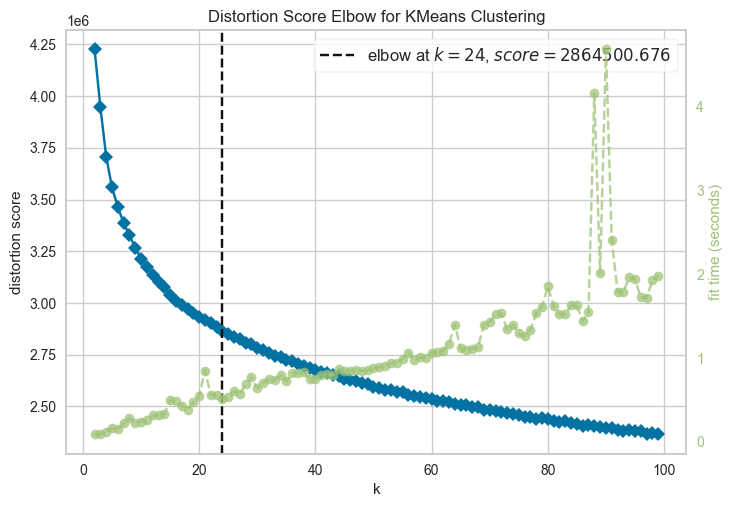

In [12]:
KMeans_Elbow(hog_descriptors_PCA, cluster_range=(2,100))

In [13]:
KMeans_clustering(hog_descriptors_PCA, n_clusters=24)

array([12, 14,  6, ..., 16, 21, 14], dtype=int32)